In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np
!pip install transformers==3.3.1
!pip install sentencepiece
import sentencepiece
from transformers import AutoModel, AutoTokenizer
from torch import cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kannada_offensive_train (1).csv', delimiter='\t', names=['text','label','nan'])
train = train.drop(columns=['nan'])
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Kannada':4, 'Offensive_Targeted_Insult_Other':5}.get)
train.head(9)

,text,label
0,Tik tok alli jagala madtidralla adra baggenu o...,0
1,Anyone from kerala here,4
2,Movie rerelease madi plss,0
3,Amazon prime alli bittidira....yella manele no...,0
4,Guru sure news nanu tik tok dawn lod madeda ya...,0
5,ಸುದೀಪ್ ಸರ್ ಅಂಡ್ ದರ್ಶನ್ ಸರ್ ಅವರಿಗೆ ಇರೋ ಫ್ಯಾನ್ಸ್...,0
6,Ade old same story,2
7,Superb rakshit sir sobg superb macking,4
8,Hai Neel (prithvi) wonderful movie dia,4


In [4]:
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kannada_offensive_dev.csv', delimiter='\t', names=['text','label','nan'])
val = val.drop(columns=['nan'])
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Kannada':4, 'Offensive_Targeted_Insult_Other':5}.get)

In [5]:
from numpy import random

In [6]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kannada_offensive_test.csv',delimiter='\t',names=['text','label'])
def addLabel():
    test['label'] = [random.choice([0, 1, 2, 3, 4, 5]) for text in test.text]
    
addLabel()
test.head(9)

,text,label
0,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,0
1,Anna nim e vedio nodinu mathe chaina apps use ...,0
2,Super anna yenu thappila yela sari agi hellidi...,4
3,Super sir super super super super,4
4,AGT-KELU (KANNADA RAP 2019),0
5,Kuladalli keelyavudo huchappa,1
6,ಶೇಕಡ 100(%) ರಷ್ಟು viruses na China ಉತ್ಪನ್ನ ಮಾಡ...,4
7,Aagle tv li haaaktidaaralla guru.....,3
8,Hindi video song . Yavaga release,5


In [7]:
import re
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply(lambda x: re.sub(r' +', ' ',x))
    df['text'] = df['text'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
    df['text'] = df['text'].str.replace('\d+', '')

clean(train)
clean(val)
clean(test)

In [8]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [9]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [10]:
MODEL_TYPE = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)

In [11]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [12]:
def create_dataloader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = False,
                    num_workers=4)

In [13]:
test_data_loader = create_dataloader(test,tokenizer,MAX_LEN,BATCH_SIZE)

In [14]:
print('Training set size:',train.shape)
print('validation set size:',val.shape)
print('Testing set size:',test.shape)

Training set size: (6217, 2)
validation set size: (777, 2)
Testing set size: (778, 2)


In [15]:
import torch.nn as nn
class XLMRobertaclass(nn.Module):
  def __init__(self, n_classes):
    super(XLMRobertaclass, self).__init__()
    self.auto = AutoModel.from_pretrained('xlm-roberta-base')
    self.drop = nn.Dropout(p=0.4)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [16]:
model = XLMRobertaclass(6)
model = model.to(device)

In [17]:
from transformers import AdamW,get_linear_schedule_with_warmup
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [19]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        label = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,label)

        correct_predictions += torch.sum(preds == label)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)
      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
 
  val_acc,val_loss = eval_model(
     model,
     val_data_loader,
     loss_fn,
     device,
     len(val)
  )

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if train_acc > best_accuracy:
    torch.save(model.state_dict(),'xlm-roberta-base.bin')
    best_accuracy = train_acc


Epoch: 01 | Epoch Time: 2m 27s
Train Loss 1.2671466304705694 accuracy 0.5592729612353226
Val Loss 1.2446149492263794 accuracy 0.5482625482625483

Epoch: 02 | Epoch Time: 2m 32s
Train Loss 1.1919795653758904 accuracy 0.57744893035226
Val Loss 1.1144695281982422 accuracy 0.6512226512226512

Epoch: 03 | Epoch Time: 2m 32s
Train Loss 1.0677953218802427 accuracy 0.6430754383142996
Val Loss 1.0305641102790832 accuracy 0.6589446589446589

Epoch: 04 | Epoch Time: 2m 32s
Train Loss 1.018325161628234 accuracy 0.6614122567154577
Val Loss 0.988194739818573 accuracy 0.6808236808236808

Epoch: 05 | Epoch Time: 2m 32s
Train Loss 0.9699186132504389 accuracy 0.685217950780119
Val Loss 0.9895690250396728 accuracy 0.6782496782496782

Epoch: 06 | Epoch Time: 2m 32s
Train Loss 0.9426101557719402 accuracy 0.6906868264436223
Val Loss 0.9749689197540283 accuracy 0.6782496782496782

Epoch: 07 | Epoch Time: 2m 32s
Train Loss 0.914519948225755 accuracy 0.702589673475953
Val Loss 0.9448464822769165 accuracy 0.697

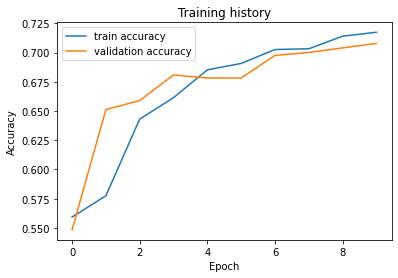

In [39]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1]);

In [40]:
val_acc.item()

0.7078507078507078

In [34]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      text = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(text)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(label)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [47]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [48]:
a = {'id':[i for i in range(778)]}
a = pd.DataFrame(a)
df = pd.DataFrame({'id':a.id,'text':y_review_texts,'label':y_pred.tolist()})
df.label = df.label.apply({0:'Not_offensive',1:'Offensive_Untargetede',2:'Offensive_Targeted_Insult_Group',3:'Offensive_Targeted_Insult_Individual',4:'not-Kannada', 5:'Offensive_Targeted_Insult_Other'}.get)
df

,id,text,label
0,0,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,Not_offensive
1,1,anna nim e vedio nodinu mathe chaina apps use ...,Not_offensive
2,2,super anna yenu thappila yela sari agi hellidi...,Not_offensive
3,3,super sir super super super super,not-Kannada
4,4,agt kelu kannada rap,Not_offensive
...,...,...,...
773,773,startup start maadalu capacity growth maadalu ...,Not_offensive
774,774,rashmika idanna nodi thi a urkimbeku🤣🤣🤣🤣🤣,Offensive_Targeted_Insult_Individual
775,775,i love you sir,not-Kannada
776,776,ನೋಡ್ತಾ ಹೋದ್ರೆ ಸಾವಿರಾರು lyrical video ಗಳು,Not_offensive


In [49]:
df.to_csv('XLMRoberta_Kannada_submission.csv',index=False)
from google.colab import files
files.download("XLMRoberta_Kannada_submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>